In [17]:
# Data proessing imports
import h5py
import numpy as np
import os
import pdb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import time
import pickle

In [20]:
# Torch Imports
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# Set up output directories 
model_dir = '/Users/quetzal/Documents/code/deep-OTD/blocking/blocking_models'
data_dir = '/Users/quetzal/Documents/code/blocking_project'
figure_dir = '/Users/quetzal/Documents/code/deep-OTD/blocking/blocking_figures'


if not os.path.exists(model_dir):
    os.mkdir(model_dir)
if not os.path.exists(data_dir):
    os.mkdir(data_dir)    
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)        

In [5]:
# Read in all 40 days of experimental data into a single 4D tensor
exp_days = 40

# Get the metadata (e.g., lat, long) from a single example data file
temp_day = 1
temp_filename = 'Z_5day_day' + str(temp_day) + '_20190730.mat'
meta_data = h5py.File(os.path.join(data_dir, temp_filename), 'r')
data_shape = np.array(meta_data['Zluck']).shape
print("Data shape:", data_shape)

# # Construct the 40 x 127 x 43 x 7079 data file, corresponding to day, lat,
# # lon, trail_no values, of top-layer quasigeostrophic potential vorticity
exp_data = np.zeros((exp_days, data_shape[0], data_shape[1], data_shape[2]));
for day in range(1, exp_days+1):
    filename = 'Z_5day_day' + str(day) + '_20190730.mat'
    print('Loading file for day ' + str(day), "from", filename)
    data = h5py.File(os.path.join(data_dir, filename), 'r');
    exp_data[day-1, :, :, :] = data['Zluck']; 

Data shape: (7079, 43, 127)
Loading file for day 1 from Z_5day_day1_20190730.mat
Loading file for day 2 from Z_5day_day2_20190730.mat
Loading file for day 3 from Z_5day_day3_20190730.mat
Loading file for day 4 from Z_5day_day4_20190730.mat
Loading file for day 5 from Z_5day_day5_20190730.mat
Loading file for day 6 from Z_5day_day6_20190730.mat
Loading file for day 7 from Z_5day_day7_20190730.mat
Loading file for day 8 from Z_5day_day8_20190730.mat
Loading file for day 9 from Z_5day_day9_20190730.mat
Loading file for day 10 from Z_5day_day10_20190730.mat
Loading file for day 11 from Z_5day_day11_20190730.mat
Loading file for day 12 from Z_5day_day12_20190730.mat
Loading file for day 13 from Z_5day_day13_20190730.mat
Loading file for day 14 from Z_5day_day14_20190730.mat
Loading file for day 15 from Z_5day_day15_20190730.mat
Loading file for day 16 from Z_5day_day16_20190730.mat
Loading file for day 17 from Z_5day_day17_20190730.mat
Loading file for day 18 from Z_5day_day18_20190730.mat


In [6]:
# Relevent constants
NUM_DAYS = exp_data.shape[0]
NUM_TRIALS = exp_data.shape[1]
NUM_LAT = exp_data.shape[2]
NUM_LON = exp_data.shape[3]

# Find the mean and std of data for normalization
data_mean = np.mean(exp_data, axis=None)
data_std = np.std(exp_data, axis=None)

# Truncate latitude and longitude data; convoluation layers behave badly with origonal 43 x 127 dimensions
LAT_TRUNC = 40
LON_TRUNC = 124
lon = meta_data['lon0'][0:LON_TRUNC]
lat = meta_data['lon0'][0:LAT_TRUNC]
lon_cord, lat_cord = np.meshgrid(lon, lat); 

In [7]:
class BlockingDataset(Dataset):
    """ Custom dataset class for reading in the blocking data

    Args:
        data (np.array): the exp_data array, which should have be a 4D numpy tensor 
            containing DAY x TRAIL x LAT x LON
    """
    def __init__(self, data, DAY_BK=20, DAY_BF=0, DAY_AF=5, DAY_PRED=3, transform=None):
        self.DAY_BK = DAY_BK
        self.DAY_BF = DAY_BF
        self.DAY_AF = DAY_AF
        self.DAY_PRED = DAY_PRED
        
        self.data = data
        
#         self.cur_state, self.prev_state, self.next_state, self.block_status = self.split_data_labels_timeseries(data)
        
        self.transform = transform
    

    def __getitem__(self, index):
        
        cur = self.data[index]
        nxt = self.next_state[index]
        dif = (self.next_state[index] - self.cur_state[index])
        bks = self.block_status[index]
        
        sample = {'cur_state': cur, 'next_state': nxt, 'diff': dif, 'bs': bks}

        # Apply relevent transformations
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return self.data.shape[0]-1-self.DAY_PRED # Can only get "next" and "prev" timsteps for data[self.DAY_PRED:-1]
    
    def split_data_labels_timeseries(self, data):
        """ Splits data into "current timestep" and "next timestep" training pairs, where
                every other sample is added to either the current or next array

        Args:
            data (np.array): the exp_data array, which should have be a 4D numpy tensor 
                containing DAY x TRAIL x LAT x LON
        """        
        duration = data.shape[0]
        num_trials = data.shape[1]
        
        cur_data = np.zeros(((duration-1)*num_trials, data.shape[2], data.shape[3]))
        next_data = np.zeros(((duration-1)*num_trials, data.shape[2], data.shape[3]))
        next_data = np.zeros(((duration-1)*num_trials, data.shape[2], data.shape[3]))
        block_status = np.zeros((duration // 2 * num_trials,))

        i = 0                      
        for trial in range(num_trials):
            for day in range(0, duration, 2): # Increase days by 2
                cur_data[i, :, :] = data[day, trial, :, :]
                next_data[i, :, :] = data[day+1, trial, :, :]
                if day < self.DAY_BK - self.DAY_BF or day > self.DAY_BK + self.DAY_AF:
                    block_status[i] = False
                else:
                    block_status[i] = True
                i += 1

        return cur_data, next_data, block_status

In [11]:
# Define data transformations

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (tuple))
        self.output_size = output_size

    def __call__(self, sample):
        cur_state, next_state, diff, bs = sample['cur_state'], sample['next_state'], sample['diff'], sample['bs']

        new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)

        cs = transform.resize(cur_state, (new_h, new_w))
        ns = transform.resize(next_state, (new_h, new_w))
        df = transform.resize(diff, (new_h, new_w))

        return {'cur_state': cs, 'next_state': ns, 'diff': df, 'bs': bs}
    
class AddDummyDim(object):
    """ Adds a dummy dimension, so that each example is a 3D tensor, with dimensions (1, *, *)
             For compatiablity with pytorch convoluation.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        cur_state, next_state, diff, bs = sample['cur_state'], sample['next_state'], sample['diff'], sample['bs']
        
        cur_state = cur_state.reshape(1, cur_state.shape[0], cur_state.shape[1]) 
        next_state = next_state.reshape(1, next_state.shape[0], next_state.shape[1]) 
        diff = diff.reshape(1, diff.shape[0], diff.shape[1]) 

        return {'cur_state': cur_state, 'next_state': next_state, 'diff': diff, 'bs': bs}
    
class Normalize(object):
    """Normalize an QGPV field to zero mean, unit variance.

    Args:
        mean (float or double): dataset mean
        std (float or double): dataset standard deviation
    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        cur_state, next_state, diff, bs = sample['cur_state'], sample['next_state'], sample['diff'], sample['bs']
        
        cur_state = (cur_state - self.mean) / self.std
        next_state = (next_state - self.mean) / self.std 
        diff = next_state - cur_state

        return {'cur_state': cur_state, 'next_state': next_state, 'diff': diff, 'bs': bs}
    

In [12]:
NUM_TRIALS = 500

# Compose relevent data transformations: normalize -> rescale -> add dummy dim
trans = transforms.Compose([Normalize(data_mean, data_std), Rescale((40, 124)), AddDummyDim()])

# Create training and testing datasets, each with a fraction of the origonal data 
blocking_dataset_train = BlockingDataset(data=exp_data[:, 0:NUM_TRIALS//2, :, :], transform=trans)
blocking_dataset_test = BlockingDataset(data=exp_data[:, NUM_TRIALS//2:NUM_TRIALS//2 + NUM_TRIALS//2, :, :], transform=trans) # TODO modify to take the rest of the dataset

In [13]:
# Create training and testing dataloaders
num_workers = 0
batch_size = 5
dataloader_train = torch.utils.data.DataLoader(blocking_dataset_train, shuffle=True, batch_size=batch_size, num_workers=num_workers)
dataloader_test = torch.utils.data.DataLoader(blocking_dataset_test, shuffle=True, batch_size=batch_size, num_workers=num_workers)

In [14]:
from matplotlib import colors

def show_blocking_batch(sample_batched):
    """Visualize a batch of data

    Args:
        sample_batched (torch.tensor): a batched data example, dimension BATCHSIZE x LAT X LON
    """    
    # Unpack and squeeze to remove dummy dimension 
    cur_state_batch, next_state_batch, diff_batch = \
            np.squeeze(sample_batched['cur_state']), \
            np.squeeze(sample_batched['next_state']), \
            np.squeeze(sample_batched['diff'])
            
    batch_size = len(cur_state_batch)
    
    # Find max and min diff values, for consitant visualization 
    diff_min = np.min(diff_batch.numpy(), axis=None)
    diff_max = np.max(diff_batch.numpy(), axis=None)

    # Plotting 
    for i in range(batch_size):
        ax1 = plt.subplot(3, batch_size, i+1)
        ax2 = plt.subplot(3, batch_size, i+1+batch_size)
        ax3 = plt.subplot(3, batch_size, i+1+2*batch_size)

        plt.tight_layout()
        
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')

        s = ax1.contourf(lon_cord, lat_cord, cur_state_batch[i, :, :], cmap=plt.cm.viridis)
        s = ax2.contourf(lon_cord, lat_cord, next_state_batch[i, :, :], cmap=plt.cm.viridis)
        s = ax3.contourf(lon_cord, lat_cord, diff_batch[i, :, :], cmap=plt.cm.bwr, vmin=diff_min, vmax=diff_max)

    plt.show()
    plt.close()

0 torch.Size([5, 1, 40, 124]) torch.Size([5, 1, 40, 124])


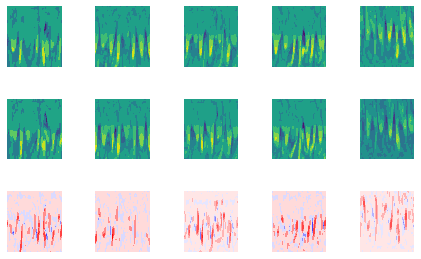

1 torch.Size([5, 1, 40, 124]) torch.Size([5, 1, 40, 124])


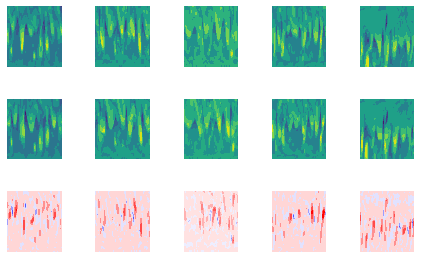

2 torch.Size([5, 1, 40, 124]) torch.Size([5, 1, 40, 124])


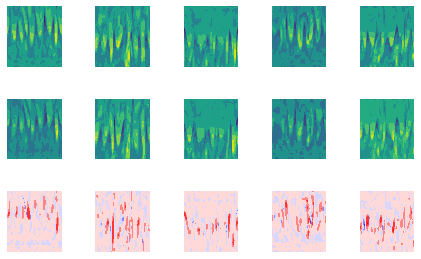

3 torch.Size([5, 1, 40, 124]) torch.Size([5, 1, 40, 124])


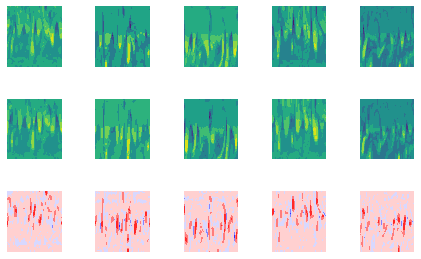

In [15]:
# Plot a few batches of data
for i_batch, sample_batched in enumerate(dataloader_train):
    print(i_batch, sample_batched['cur_state'].size(),
          sample_batched['next_state'].size())
    show_blocking_batch(sample_batched)
        
    # Only display the first few sampled bataches
    if i_batch > 2:
        break

In [42]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*7*28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x)) 
        return x
    
model = ConvNet()
print(model)

ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)


In [43]:
# Specify obejctive and optimizer for CNN classifier
criterion = nn.BCELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [56]:
# number of epochs to train the model
n_epochs = 30

loss_progress = [0]*n_epochs
val_progress = [0]*n_epochs


for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in dataloader_train:
        # no need to flatten images
        cur_state, next_state, diff, block_status = data['cur_state'], data['next_state'], data['diff'], data['bs']
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        outputs = model(cur_state.float())
        loss = criterion(outputs, block_status)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()

        # update running training loss
        train_loss += loss.item()*cur_state.size(0) # Multiply by the batch size
        
    ########################################
    # run current model on validation data #
    ########################################
    with torch.no_grad():
        for data in dataloader_test:        
            cur_state, next_state, diff, block_status = data['cur_state'], data['next_state'], data['diff'], data['bs']        
            # Validation outputs
            outputs = model(cur_state.float())
            loss = criterion(outputs, block_status)
            val_loss += loss.item()*cur_state.size(0) # Multiply by the batch size

    # print avg training statistics 
    train_loss = train_loss/len(dataloader_train)
    val_loss = val_loss/len(dataloader_test)

    loss_progress[epoch-1] = train_loss
    val_progress[epoch-1] = val_loss

    print('Epoch: {} \tTraining Loss: {:.10f} \tValidation Loss: {:.10f}'.format(
        epoch, 
        train_loss,
        val_loss
        ))

Epoch: 1 	Training Loss: 0.6143482283 	Validation Loss: 2.1352964177
Epoch: 2 	Training Loss: 0.5262991095 	Validation Loss: 2.0602505891
Epoch: 3 	Training Loss: 0.4078171607 	Validation Loss: 2.3381000255
Epoch: 4 	Training Loss: 0.3898055579 	Validation Loss: 2.3052677455
Epoch: 5 	Training Loss: 0.3349245880 	Validation Loss: 2.4184034847
Epoch: 6 	Training Loss: 0.3379062081 	Validation Loss: 2.7074172552
Epoch: 7 	Training Loss: 0.2784483964 	Validation Loss: 3.3478071636
Epoch: 8 	Training Loss: 0.2209251752 	Validation Loss: 3.9208962424
Epoch: 9 	Training Loss: 0.2660666889 	Validation Loss: 3.5201507335
Epoch: 10 	Training Loss: 0.2134527103 	Validation Loss: 3.1869725726
Epoch: 11 	Training Loss: 0.2068256898 	Validation Loss: 3.3299164302
Epoch: 12 	Training Loss: 0.2134859245 	Validation Loss: 3.2783644629
Epoch: 13 	Training Loss: 0.2135366090 	Validation Loss: 4.1270927419
Epoch: 14 	Training Loss: 0.1950401570 	Validation Loss: 3.5645079743
Epoch: 15 	Training Loss: 0.1

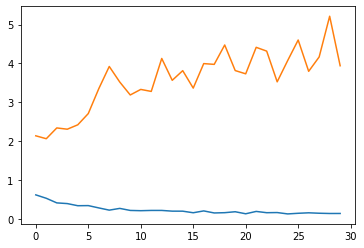

In [57]:
# Plot validation and training loss with epoch
plt.plot(loss_progress)
plt.plot(val_progress)

In [ ]:
# Save the model
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
fh = open(os.path.join(model_dir, 'blocking_model_epochs' + str(n_epochs) + '.pickle'), 'wb')
pickle.dump([model, dataloader_train, dataloader_test], fh)

In [ ]:
# Load the model
LOAD = False # Flag for safety, don't override
if LOAD:
    fh = open(os.path.join(model_dir, 'blocking_model_epochs' + str(n_epochs) + '.pickle'), 'rb')
    model_, dataloader_train_, dataloader_test_ = pickle.load(fh)

In [ ]:
from matplotlib import colors

def show_predictions(sample, model):
    """Visualize a batch of data

    Args:
        sample (torch.tensor): a batched data example, dimension BATCHSIZE x LAT X LON
        model (torch.nn): the convoluational autoencoder model
    """        
    cur_state_batch, next_state_batch, diff_batch = \
            sample_batched['cur_state'], \
            sample_batched['next_state'], \
            sample_batched['diff']
    
    with torch.no_grad():
        outputs_batch = model(cur_state_batch.float())
    
        cur_state_batch = np.squeeze(cur_state_batch)
        next_state_batch = np.squeeze(next_state_batch)
        diff_batch = np.squeeze(diff_batch)
        outputs_batch = np.squeeze(outputs_batch)
        
        min_diff = np.min([diff_batch.numpy(), outputs_batch.numpy()])
        max_diff = np.max([diff_batch.numpy(), outputs_batch.numpy()])


    batch_size = len(cur_state_batch)    
    for i in range(batch_size):
        ax1 = plt.subplot(4, batch_size, i+1)
        ax2 = plt.subplot(4, batch_size, i+1+batch_size)
        ax3 = plt.subplot(4, batch_size, i+1+2*batch_size)
        ax4 = plt.subplot(4, batch_size, i+1+3*batch_size)

        plt.tight_layout()
        
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax4.axis('off')
        
        s1 = ax1.contourf(lon_cord, lat_cord, cur_state_batch[i, :, :], cmap=plt.cm.viridis)
        s2 = ax2.contourf(lon_cord, lat_cord, diff_batch[i, :, :], cmap=plt.cm.bwr, vmin=min_diff, vmax=max_diff)
        s3 = ax3.contourf(lon_cord, lat_cord, outputs_batch[i, :, :], cmap=plt.cm.bwr, vmin=min_diff, vmax=max_diff)
        s4 = ax4.contourf(lon_cord, lat_cord, np.abs(diff_batch[i, :, :] - outputs_batch[i, :, :]), cmap=plt.cm.bwr, vmin=min_diff, vmax=max_diff)


    plt.show()
    plt.close()

In [ ]:
########################################
# run current model on validation data #
########################################
for i, data in enumerate(dataloader_test):        
    print(i, "Cur State", "Diff", "Pred Diff", "Pred Error")
    show_predictions(data, model)
    
    if i > 4:
        break